In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!cp -r '$root/utils' .

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import nltk
import pickle
import keras
import string
import re
import time

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.evaluation import plot_history, evaluate

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def map_special_strings(column):
    token_encoding = {
            ':)': ' xxsmilingfacexx ',
            ':]': ' xxsmilingfacexx ',
            ':-)': ' xxsmilingfacexx ',
            ';)': ' xxwinksmilingfacexx ',
            ':(': ' xxsadfacexx ',
            ':-(': ' xxsadfacexx ',
            ';(': ' xxcryingsadfacexx ',
            ':|': ' xxblankfacexx ',
            ':o': ' xxsurprisedfacexx ',
            ':/': ' xxwryfacexx ',
            ':D': ' xxgrinfacexx ',
            ';D': ' xxwinkgrinfacexx ',
            ':P': ' xxtonguefacexx ',
            ':p': ' xxtongueface2xx ',
            ';p': ' xxtongueface2xx ',
            '<3': ' xxheartxx '
    }

    column = (column
        .str.replace(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', 'xxurlxx', regex=True)
        .str.replace(r'\bu/\w+', 'xxuserxx', regex=True)
    )

    for token, encoding in token_encoding.items():
        pattern = re.compile(r'{}+(?!\S)'.format(re.escape(token)))
        column = column.str.replace(pattern, fr' {encoding} ', regex=True)

    column = (column
        .str.replace(r'[-+]?[.\d]*[\d]+[:,.\d]*', ' xxnumberxx ', regex=True)
        .str.replace(r'\b([a-zA-Z]+?)(.)\2{2,}\b', r'\1\2 xxelongxx ', regex=True)
        .str.replace(r"(\b[^a-z0-9\W()<>'`\-]{2,}\b)", r'\1 xxallcapsxx ', regex=True)
    )

    return column

In [ ]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
def vectorize_data(data, max_features=10000):
    all_sw = list(sklear_stopwords) + stopwords.words('english')
    count_vectorizer = CountVectorizer(
        stop_words=all_sw,
        token_pattern=r'(?u)\b\w\w+\b|\!|\?|\.\.\.|\*|\"',
        ngram_range=(1,3),
        max_features=max_features
    )

    vec_data = {}
    vec_data['train'] = count_vectorizer.fit_transform(data[0])
    vec_data['val'] = count_vectorizer.transform(data[1])
    vec_data['test'] = count_vectorizer.transform(data[2])

    return count_vectorizer, vec_data

# prepare data

In [ ]:
df = pd.read_csv(root+'data/train_balanced_partly_preprocessed.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [ ]:
df['comment'] = map_special_strings(df['comment'])
df['parent_comment'] = map_special_strings(df['parent_comment'])

In [ ]:
X = df[['comment', 'parent_comment']]
y = df['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((722210, 2), (200615, 2), (80246, 2))

# content-based

In [ ]:
count_vectorizer, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(vec_data['train']), y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(vec_data['val']), y_val)).batch(128)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(vec_data['train'].shape[1],)),
    Dense(100, activation='relu', kernel_initializer='he_normal',
          kernel_regularizer=L1L2(l1=2e-6, l2=2e-6)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_7/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_7/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_7/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


6851/6851 [==============================] - 83s 12ms/step - loss: 0.6452 - bc: 0.6054 - accuracy: 0.6704 - val_loss: 0.6447 - val_bc: 0.5945 - val_accuracy: 0.6808
Epoch 2/50
6851/6851 [==============================] - 75s 11ms/step - loss: 0.6447 - bc: 0.5924 - accuracy: 0.6817 - val_loss: 0.6423 - val_bc: 0.5898 - val_accuracy: 0.6847
Epoch 3/50
6851/6851 [==============================] - 75s 11ms/step - loss: 0.6427 - bc: 0.5894 - accuracy: 0.6839 - val_loss: 0.6420 - val_bc: 0.5890 - val_accuracy: 0.6862
Epoch 4/50
6851/6851 [==============================] - 75s 11ms/step - loss: 0.6409 - bc: 0.5872 - accuracy: 0.6866 - val_loss: 0.6405 - val_bc: 0.5875 - val_accuracy: 0.6875
Epoch 5/50
6851/6851 [==============================] - 74s 11ms/step - loss: 0.6388 - bc: 0.5854 - accuracy: 0.6883 - val_loss: 0.6405 - val_bc: 0.5869 - val_accuracy: 0.6884
Epoch 6/50
6851/6851 [==============================] - 75s 11ms/step - loss: 0.6378 - bc: 0.5846 - accuracy: 0.6891 - val_loss: 0.

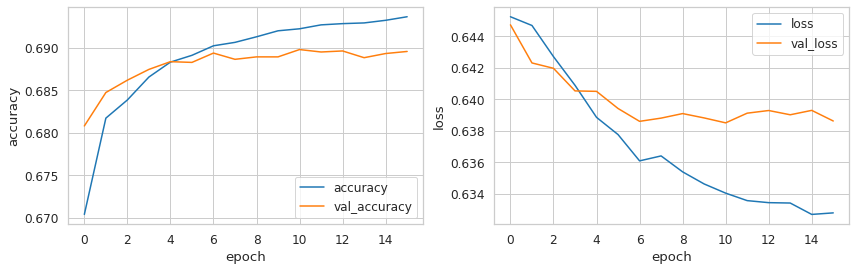

In [ ]:
plot_history(fit)

# context-based

In [ ]:
_, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])
_, vec_data_par = vectorize_data([X_train['parent_comment'], X_val['parent_comment'], X_test['parent_comment']])

In [ ]:
train_data = {'comment': sparse_tensor(vec_data['train']), 'parent': sparse_tensor(vec_data_par['train'])}
val_data = {'comment': sparse_tensor(vec_data['val']), 'parent': sparse_tensor(vec_data_par['val'])}
test_data = {'comment': sparse_tensor(vec_data['test']), 'parent': sparse_tensor(vec_data_par['test'])}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, y_val)).batch(128)

In [ ]:
comment_input =  Input(shape=(vec_data['train'].shape[1],), name='comment')
parent_input = Input(shape=(vec_data_par['train'].shape[1],), name='parent')

com = Dense(100, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=L1L2(l1=2e-6, l2=2e-6))(comment_input)
com = BatchNormalization()(com)

par = Dense(100, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=L1L2(l1=2e-6, l2=2e-6))(parent_input)
par = BatchNormalization()(par)

x = Concatenate()([com, par])
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_9/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_9/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/dense_9/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_10/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_10/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=

6851/6851 [==============================] - 118s 17ms/step - loss: 0.6712 - bc: 0.6027 - accuracy: 0.6734 - val_loss: 0.6700 - val_bc: 0.5901 - val_accuracy: 0.6861
Epoch 2/50
6851/6851 [==============================] - 115s 17ms/step - loss: 0.6690 - bc: 0.5878 - accuracy: 0.6860 - val_loss: 0.6646 - val_bc: 0.5849 - val_accuracy: 0.6906
Epoch 3/50
6851/6851 [==============================] - 115s 17ms/step - loss: 0.6620 - bc: 0.5832 - accuracy: 0.6901 - val_loss: 0.6615 - val_bc: 0.5843 - val_accuracy: 0.6911
Epoch 4/50
6851/6851 [==============================] - 117s 17ms/step - loss: 0.6555 - bc: 0.5804 - accuracy: 0.6929 - val_loss: 0.6566 - val_bc: 0.5829 - val_accuracy: 0.6921
Epoch 5/50
6851/6851 [==============================] - 114s 17ms/step - loss: 0.6515 - bc: 0.5786 - accuracy: 0.6939 - val_loss: 0.6542 - val_bc: 0.5827 - val_accuracy: 0.6931
Epoch 6/50
6851/6851 [==============================] - 107s 16ms/step - loss: 0.6480 - bc: 0.5771 - accuracy: 0.6952 - val_lo

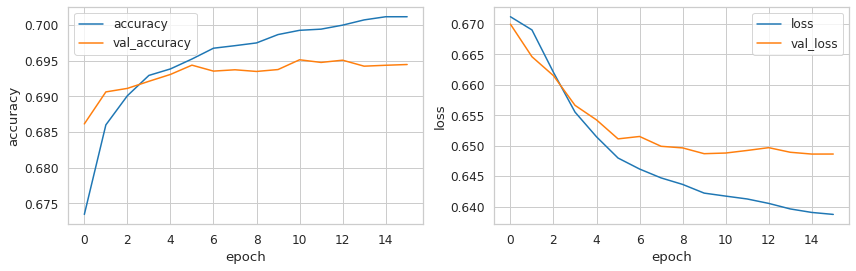

In [ ]:
plot_history(fit)

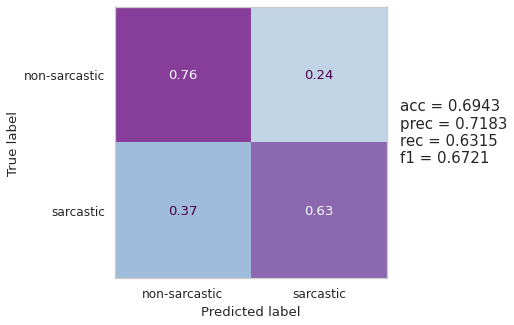

In [ ]:
evaluate(model, test_data, y_test)

# final runs

In [ ]:
df = pd.read_csv(root+'data/all_balanced_partly_preprocessed.csv')
df.shape

(1252649, 3)

In [ ]:
df['comment'] = map_special_strings(df['comment'])
df['parent_comment'] = map_special_strings(df['parent_comment'])

In [ ]:
X = df[['comment', 'parent_comment']]
y = df['label'].values

In [ ]:
# random_seeds = np.random.randint(0, 100, size=3)
# random_seeds

array([83, 91, 61])

In [ ]:
random_seeds = [83, 91, 61]

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
def pseudo_validation(define_model, X, y, random_seeds, name, context=False):
    highest_acc = 0
    results = []

    for seed in random_seeds:
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=seed)
        X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5, random_state=seed)
        
        if not context:
            count_vectorizer, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])

            train_data = sparse_tensor(vec_data['train'])
            val_data = sparse_tensor(vec_data['val'])
            test_data = sparse_tensor(vec_data['test'])

            input_shape = vec_data['train'].shape[1]

        else:
            _, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])
            _, vec_data_par = vectorize_data([X_train['parent_comment'], X_val['parent_comment'], X_test['parent_comment']])

            train_data = {'comment': sparse_tensor(vec_data['train']), 'parent': sparse_tensor(vec_data_par['train'])}
            val_data = {'comment': sparse_tensor(vec_data['val']), 'parent': sparse_tensor(vec_data_par['val'])}
            test_data = {'comment': sparse_tensor(vec_data['test']), 'parent': sparse_tensor(vec_data_par['test'])}

            input_shape = (vec_data['train'].shape[1], vec_data_par['train'].shape[1])
        
        train_dataset = tf.data.Dataset.from_tensor_slices((train_data, y_train)).shuffle(100).batch(128)
        val_dataset = tf.data.Dataset.from_tensor_slices((val_data, y_val)).batch(128)

        model = define_model(input_shape)

        binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
        es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)
        timeit = TimeHistory()

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
        start_time = time.time()
        fit = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[es, timeit], verbose=0)
        end_time = time.time()

        y_pred = model.predict(test_data).round().flatten()
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        times = timeit.times
        n_epochs = len(times)
        avg_time_per_epoch = np.mean(times)
        total_time = np.sum(times)
        total_time_2 = end_time - start_time

        results.append([seed, acc, prec, rec, f1, n_epochs, avg_time_per_epoch, total_time, total_time_2])
        columns = ['seed', 'acc', 'prec', 'rec', 'f1', 'n_epochs', 'avg_time_per_epoch', 'total_time', 'total_time_2']

        res_df = pd.DataFrame(results, columns=columns)
        res_df.to_csv(root+fr'final_results/{name}.csv', index=False)

        if acc > highest_acc:
            highest_acc = acc
            model.save(root+'models/'+name)

        print(fr'run number {len(results)} done')

In [ ]:
def bow_content(input_shape):
    model = Sequential([
        InputLayer(input_shape=(input_shape,)),
        Dense(100, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=L1L2(l1=2e-6, l2=2e-6)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
def bow_context(input_shape):
    comment_input =  Input(shape=(input_shape[0],), name='comment')
    parent_input = Input(shape=(input_shape[1],), name='parent')

    com = Dense(100, activation='relu', kernel_initializer='he_normal',
                kernel_regularizer=L1L2(l1=2e-6, l2=2e-6))(comment_input)
    com = BatchNormalization()(com)

    par = Dense(100, activation='relu', kernel_initializer='he_normal',
                kernel_regularizer=L1L2(l1=2e-6, l2=2e-6))(parent_input)
    par = BatchNormalization()(par)

    x = Concatenate()([com, par])
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
    return model

In [ ]:
pseudo_validation(bow_content, X, y, random_seeds, name='bag_of_words')

In [ ]:
pd.read_csv(root+'final_results/bag_of_words.csv')

,seed,acc,prec,rec,f1,n_epochs,avg_time_per_epoch,total_time,total_time_2
0,83,0.689262,0.726760,0.598803,0.656606,14,61.206024,856.884336,962.223888
1,91,0.688469,0.709676,0.629665,0.667281,22,60.818830,1338.014253,1570.513834
2,61,0.690726,0.720111,0.616074,0.664042,21,60.031352,1260.658399,1414.546453


In [ ]:
pseudo_validation(bow_context, X, y, random_seeds, name='context_bag_of_words', context=True)

In [ ]:
pd.read_csv(root+'final_results/context_bag_of_words.csv')

,seed,acc,prec,rec,f1,n_epochs,avg_time_per_epoch,total_time,total_time_2
0,83,0.691396,0.724527,0.609841,0.662256,20,39.884813,797.696252,800.002938
1,91,0.693664,0.714730,0.636648,0.673433,13,39.756593,516.835706,517.781237
2,61,0.694286,0.717723,0.632594,0.672475,10,39.870687,398.706867,399.723175


In [ ]:
def univariate_fs(X, y, seed, scorer, scores_filename, k='all'):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=seed)
    count_vectorizer, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])

    kbest = SelectKBest(scorer, k=k)

    X_train = kbest.fit_transform(vec_data['train'], y_train)
    X_val = kbest.transform(vec_data['val'])
    X_test = kbest.transform(vec_data['test'])

    df_scores = pd.DataFrame({
        'feature': count_vectorizer.get_feature_names_out(),
        'score': kbest.scores_
    })
    
    df_scores = df_scores.sort_values('score', ascending=False, ignore_index=True)
    df_scores.to_csv(root+fr'univariate_fs/{scores_filename}.csv', index=False)

    return df_scores

In [ ]:
f_scores = univariate_fs(X, y, 91, f_classif, 'f_scores')
f_scores.head(20)

,feature,score
0,!,17364.741821
1,yeah,12942.642174
2,obviously,5959.767662
3,totally,4697.362999
4,clearly,3945.858166
5,racist,2366.425632
6,wow,2038.025058
7,right,1975.189062
8,yes,1971.529410
9,right ?,1939.459606


# permutation importance

In [ ]:
!pip install eli5
!pip install scikeras[tensorflow]

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=61)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5, random_state=61)

count_vectorizer, vec_data = vectorize_data([X_train['comment'], X_val['comment'], X_test['comment']])
input_shape = vec_data['train'].shape[1]

In [ ]:
model = bow_content()
model.load_weights(root+'models/bag_of_words/variables/variables')

In [ ]:
model = KerasClassifier(model=model, loss='binary_crossentropy', optimizer='adam', verbose=0,
                        batch_size=512, validation_split=0.15, epochs=15, metrics='accuracy')

In [ ]:
model.initialize(vec_data['train'][:100].toarray(), y_train[:100]);

In [ ]:
indices = np.random.choice(len(y_test), size=10000)

In [ ]:
imp = PermutationImportance(model, scoring='accuracy', random_state=61)
perm = imp.fit(vec_data['test'][indices].toarray(), y_test[indices])

In [ ]:
df_imp = pd.DataFrame({
    'feature': count_vectorizer.get_feature_names_out().tolist(),
    'weight': perm.feature_importances_
}).sort_values('weight', ascending=False)

df_imp.to_csv(root+'df_imp_10000.csv', index=False)

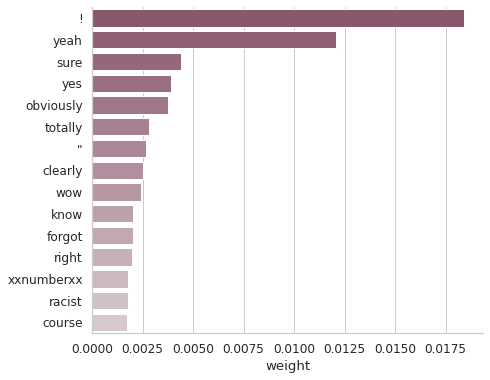

In [ ]:
plt.figure(figsize=(7,6))
sns.barplot(data=df_imp.head(15), y='feature', x='weight',
            palette=sns.light_palette('#944e6c', reverse=True, n_colors=20));
sns.despine(top=True, right=True)
plt.ylabel('')
plt.savefig('feature_imp.pdf', bbox_inches='tight')